In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import re
#nltk.download('stopwords')
from nltk.corpus import stopwords

In [29]:
def perfil_sentimientos(df):
    print(target)
    print("=" * 12)
    print(f"Positivos: {round(100 * np.mean(df.sentimiento > 0), 2)}")
    print(f"Neutro: {round(100 * np.mean(df.sentimiento == 0), 2)}")
    print(f"Negativos: {round(100 * np.mean(df.sentimiento < 0), 2)}")
    print(" ")



In [3]:
def limpiar_tokenizar(texto):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''
    
    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    
    return(nuevo_texto)

In [4]:
# Eliminaremos los artículos, proposiciones (stopwords) y otras palabras que no aportan un valor conceptual en nuestros tweets

def limpiar_tokenizar(texto):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''
    
    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    
    return(nuevo_texto)


# Eliminando las stopwords de inglés




In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eragr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [122]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [123]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### 3. Limpieza y procesamiento del los tweets

In [124]:
# Realizamos la limpieza para cada uno de los tweets

train['texto_tokenizado'] = train['text'].apply(lambda x: limpiar_tokenizar(x))
train.head()

,id,keyword,location,text,target,texto_tokenizado
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[our, deeds, are, the, reason, of, this, earth..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[all, residents, asked, to, shelter, in, place..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[people, receive, wildfires, evacuation, order..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[just, got, sent, this, photo, from, ruby, ala..."


In [126]:
# Ahora por cada token se tendra una fila (con mismo id, keyword, location y target), con el objetivo de facilitar 
# la exploración de data

# Unnest de la columna texto_tokenizado
# ==============================================================================
tweets_tidy = train.explode(column='texto_tokenizado')
tweets_tidy = tweets_tidy.drop(columns='text')
tweets_tidy = tweets_tidy.rename(columns={'texto_tokenizado':'token'})
tweets_tidy.head()

,id,keyword,location,target,token
0,1,NaN,NaN,1,our
0,1,NaN,NaN,1,deeds
0,1,NaN,NaN,1,are
0,1,NaN,NaN,1,the
0,1,NaN,NaN,1,reason


### 4. Frecuencia 

In [127]:
# Total de palabras utilizadas en tweets de desastre y no desastre
# ==============================================================================
print('--------------------------')
print('Palabras por real desastre (1) o no (0) ')
print('--------------------------')
tweets_tidy.groupby(by='target')['token'].count()

--------------------------
Palabras por real desastre (1) o no (0) 
--------------------------


target
0    57628
1    44380
Name: token, dtype: int64

Se tienen 13 mil palabras más provenientes de tweets con desastres reales.

#### Palabras más utilizadas en tweets desastres reales o no

In [128]:
# Encontramos las 10 palabras más utilizadas en los tipos de tweets
# Encontramos el listado de stopwords en inglés
stop_words = list(stopwords.words('english'))
# Se añade la stoprword: amp, ax, ex
stop_words.extend(("amp", "xa", "xe", "like", "get", "would", "know","got","one","us","see","still","going","california"))
print(stop_words[:10])

# Filtrado para excluir stopwords
# ==============================================================================
tweets_tidy = tweets_tidy[~(tweets_tidy["token"].isin(stop_words))]

tweets_tidy.groupby(['target','token'])['token'] \
 .count() \
 .reset_index(name='count') \
 .groupby('target') \
 .apply(lambda x: x.sort_values('count', ascending=False).head(10))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


target      token  count
target                                
0      6973        0        new    168
       1147        0       body    115
       11004       0        via     99
       11025       0      video     96
       7596        0     people     95
       6110        0       love     90
       10427       0       time     88
       2529        0        day     86
       713         0       back     85
       4075        0       full     83
1      14501       1       fire    180
       16831       1       news    151
       19806       1        via    121
       13817       1   disaster    121
       18962       1    suicide    112
       17461       1     police    109
       17307       1     people    105
       15846       1     killed     95
       15183       1  hiroshima     93
       18868       1      storm     89

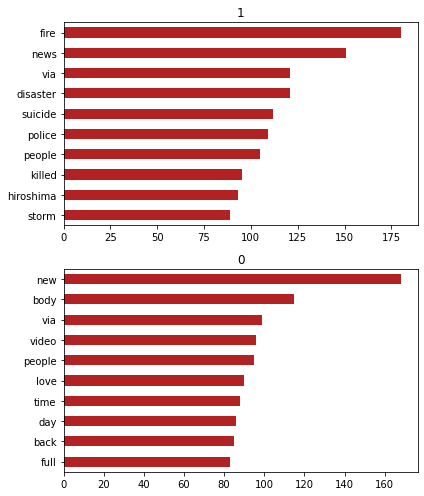

In [129]:

fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(6, 7))
for i, target in enumerate(tweets_tidy.target.unique()):
    df_temp = tweets_tidy[tweets_tidy.target == target]
    counts  = df_temp['token'].value_counts(ascending=False).head(10)
    counts.plot(kind='barh', color='firebrick', ax=axs[i])
    axs[i].invert_yaxis()
    axs[i].set_title(target)

fig.tight_layout()

**¿Qué   palabras   cree   que   le   servirán   para   hacer   un   mejor   modelo   de
clasificación?**

Palabras clave para tweets de desastres podrían ser: fire, disaster, news, suicide, police y killed

Palabras clave pra tweets de no desastres: body, love, video, time, youtube, gt

Las palabras **via** aparece en ambos tipos de tweets. La palabra **emergency** es un distractor porque aparece en tweets que no hablan de desastres reales y la palbra **fire** podría ser confusa por su alta frecuencia en ambos tipos de tweets.

In [131]:
# Cálculo term-frecuency (tf)
# ==============================================================================
tf = tweets_tidy.copy()
# Número de veces que aparece cada término en cada tweet
tf = tf.groupby(["id", "token"])["token"].agg(["count"]).reset_index()
# Se añade una columna con el total de términos por tweet
tf['total_count'] = tf.groupby('id')['count'].transform(sum)
# Se calcula el tf
tf['tf'] = tf["count"] / tf["total_count"]
tf.sort_values(by = "tf").head(5)

,id,token,count,total_count,tf
16544,2793,rite,1,23,0.043478
16534,2793,curfew,1,23,0.043478
16535,2793,dem,1,23,0.043478
16538,2793,itz,1,23,0.043478
16539,2793,knw,1,23,0.043478


In [132]:
# Inverse document frequency
# ==============================================================================
idf = tweets_tidy.copy()
total_documents = idf["id"].drop_duplicates().count()
# Número de documentos (tweets) en los que aparece cada término
idf = idf.groupby(["token", "id"])["token"].agg(["count"]).reset_index()
idf['n_documentos'] = idf.groupby('token')['count'].transform(sum)
# Cálculo del idf
idf['idf'] = np.log(total_documents / idf['n_documentos'])
idf = idf[["token","n_documentos", "idf"]].drop_duplicates()
idf.sort_values(by="idf").head(3)

,token,n_documentos,idf
21021,fire,252,3.408184
38703,new,225,3.521512
60471,via,220,3.543985


In [133]:
# Term Frequency - Inverse Document Frequency
# ==============================================================================
tf_idf = pd.merge(left=tf, right=idf, on="token")
tf_idf["tf_idf"] = tf_idf["tf"] * tf_idf["idf"]
tf_idf.sort_values(by="id").head()

,id,token,count,total_count,tf,n_documentos,idf,tf_idf
0,1,allah,1,6,0.166667,9,6.740388,1.123398
144,1,reason,1,6,0.166667,20,5.941880,0.990313
57,1,may,1,6,0.166667,89,4.448976,0.741496
9,1,deeds,1,6,0.166667,2,8.244465,1.374078
55,1,forgive,1,6,0.166667,2,8.244465,1.374078


In [75]:
# Reparto train y test
# ==============================================================================
datos_X = train.loc[train.target.isin([0, 1]), 'text']
datos_y = train.loc[train.target.isin([0, 1]), 'target']

X_train, X_test, y_train, y_test = train_test_split(
    datos_X,
    datos_y,
    test_size = 0.2,
    random_state = 123
    
)


In [76]:
value, counts = np.unique(y_train, return_counts=True)
print(dict(zip(value, 100 * counts / sum(counts))))
value, counts = np.unique(y_test, return_counts=True)
print(dict(zip(value, 100 * counts / sum(counts))))

{0: 56.86371100164204, 1: 43.13628899835796}
{0: 57.715036112934996, 1: 42.284963887065004}


In [18]:
stop_words = list(stopwords.words('english'))
# Se añade la stopword: amp, ax, ex
stop_words.extend(("amp", "xa", "xe"))
# Creación de la matriz tf-idf
# ==============================================================================
tfidf_vectorizador = TfidfVectorizer(
                        tokenizer  = limpiar_tokenizar,
                        min_df     = 3,
                        stop_words = stop_words
                    )
tfidf_vectorizador.fit(X_train)

C:\Users\eragr\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


TfidfVectorizer(min_df=3,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function limpiar_tokenizar at 0x000001AACA4F35E0>)

In [19]:
tfidf_train = tfidf_vectorizador.transform(X_train)
tfidf_test  = tfidf_vectorizador.transform(X_test)
print(f" Número de tokens creados: {len(tfidf_vectorizador.get_feature_names())}")
print(tfidf_vectorizador.get_feature_names()[:10])

 Número de tokens creados: 3616
['aba', 'abandoned', 'abbswinston', 'abc', 'abcnews', 'abe', 'ability', 'ablaze', 'able', 'abortion']


# Modelo SVM lineal

In [20]:
# Entrenamiento del modelo SVM
# ==============================================================================
modelo_svm_lineal = svm.SVC(kernel= "linear", C = 1.0)
modelo_svm_lineal.fit(X=tfidf_train, y= y_train)

# Grid de hiperparámetros
# ==============================================================================
param_grid = {'C': np.logspace(-5, 3, 10)}

# Búsqueda por validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = svm.SVC(kernel= "linear"),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = -2,
        cv         = 5, 
        verbose    = 0,
        return_train_score = True
      )

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid.fit(X = tfidf_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)

,param_C,mean_test_score,std_test_score,mean_train_score,std_train_score
5,0.278256,0.790148,0.011071,0.848153,0.004046
6,2.154435,0.779146,0.013461,0.920936,0.002464
7,16.681005,0.730870,0.013654,0.971511,0.001193
8,129.154967,0.714778,0.017575,0.984442,0.000353
9,1000.0,0.712644,0.020679,0.985591,0.000239
4,0.035938,0.578161,0.002668,0.578571,0.001659
0,0.00001,0.568637,0.000402,0.568637,0.000101
1,0.000077,0.568637,0.000402,0.568637,0.000101
2,0.000599,0.568637,0.000402,0.568637,0.000101
3,0.004642,0.568637,0.000402,0.568637,0.000101


In [21]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

modelo_final = grid.best_estimator_

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'C': 0.2782559402207126} : 0.7901477832512315 accuracy


In [22]:
# Error predicciones test
# ==============================================================================
predicciones_test = modelo_final.predict(X=tfidf_test)

print("-------------")
print("Error de test")
print("-------------")

print(f"Número de clasificaciones erróneas de un total de {tfidf_test.shape[0]} " \
      f"clasificaciones: {(y_test != predicciones_test).sum()}"
)
print(f"% de error: {100*(y_test != predicciones_test).mean()}")

print("")
print("-------------------")
print("Matriz de confusión")
print("-------------------")
pd.DataFrame(confusion_matrix(y_true = y_test, y_pred= predicciones_test),
             columns= [0, 1],
             index = [0, 1])

-------------
Error de test
-------------
Número de clasificaciones erróneas de un total de 1523 clasificaciones: 302
% de error: 19.829284307288248

-------------------
Matriz de confusión
-------------------


,0,1
0,817,62
1,240,404


# Analisis sentimientos

In [52]:
# Descarga lexicon sentimientos
# Es un diccionario de palabras que clasifica una palabra como positiva o negativa, en escala de -5 a 5.

lexicon = pd.read_table(
            'https://raw.githubusercontent.com/fnielsen/afinn/master/afinn/data/AFINN-en-165.txt',
            names = ['termino', 'sentimiento']
          )
lexicon.head()

,termino,sentimiento
0,abandon,-2
1,abandoned,-2
2,abandons,-2
3,abducted,-2
4,abduction,-2


In [53]:
# Sentimiento promedio de cada tweet
# ==============================================================================
tweets_sentimientos = pd.merge(
                            left     = tweets_tidy,
                            right    = lexicon,
                            left_on  = "token", 
                            right_on = "termino",
                            how      = "inner"
                      )
tweets_sentimientos = tweets_sentimientos.drop(columns = "termino")


In [56]:

# Se suman los sentimientos de las palabras que forman cada tweet.
tweets_sentimientos = tweets_sentimientos[["target", "id", "sentimiento"]] \
                      .groupby(["target", "id"])\
                      .sum().reset_index()
tweets_sentimientos.head()


,target,id,sentimiento
0,0,24,3
1,0,25,3
2,0,31,-3
3,0,32,1
4,0,33,3


In [57]:
for target, df in tweets_sentimientos.groupby("target"):
    perfil_sentimientos(df)

0
Positivos: 35.54
Neutro: 5.15
Negativos: 59.3
 
1
Positivos: 15.77
Neutro: 3.52
Negativos: 80.7
 


**Nota** Vemos que los tweets que no hablan de desastres son un 65% más negativos que positivos, mientras que los tweets de desastres son un 80.7% negativos, superando en gran medida a los positivos.

#### Tweets más negativos y positivos

In [58]:

tweets_sentimientos.sort_values(by=['sentimiento'], inplace=True, ascending=False)
tweets_sentimientos.head(10)

,target,id,sentimiento
2921,0,10028,14
2075,0,7140,12
1422,0,4844,11
1347,0,4541,11
438,0,1453,11
1960,0,6697,11
5051,1,8989,10
72,0,344,10
2740,0,9386,10
814,0,2744,10


**Comentario.** Solo uno de los tweets fue "mal" clasificado, pues está en categoría 1 (desastre), pero sentimentalmente se consideró como positivoa


In [59]:
tweets_sentimientos.sort_values(by=['sentimiento'], inplace=True, ascending=True)
tweets_sentimientos.head(10)

,target,id,sentimiento
3060,0,10689,-26
2913,0,10011,-19
2259,0,7749,-17
4288,1,5153,-15
4269,1,5113,-15
4274,1,5127,-15
4275,1,5130,-15
4280,1,5137,-15
3763,1,3091,-15
4291,1,5157,-15


**Comentario.** Los tres tweets más negativos fueron de categoría 0 (no desastre), esto porque algunos de los tweets tipo 0 no necesariamente son buenos, de hecho son un 40% negativos, aún así la mayoría de estos 10 fueron de tipo 1.

In [140]:
tweets_sentimientos

,target,id,sentimiento
3060,0,10689,-26
2913,0,10011,-19
2259,0,7749,-17
4288,1,5153,-15
4269,1,5113,-15
...,...,...,...
438,0,1453,11
1347,0,4541,11
1422,0,4844,11
2075,0,7140,12


# Ultimo

In [179]:
train2 = pd.merge(
                            left     = train,
                            right    = tweets_sentimientos,
                            left_on  = "id", 
                            right_on = "id",
                            how      = "inner"
                      )

train2=train2.drop(columns = "target_y")
train2.rename(columns = {'target_x':'target'}, inplace = True)


In [180]:
# Realizamos la limpieza para cada uno de los tweets

train2['texto_tokenizado'] = train2['text'].apply(lambda x: limpiar_tokenizar(x))
train2.head()

,id,keyword,location,text,target,texto_tokenizado,sentimiento
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[our, deeds, are, the, reason, of, this, earth...",1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, canada]",-2
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[all, residents, asked, to, shelter, in, place...",-1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[people, receive, wildfires, evacuation, order...",-1
4,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,"[rockyfire, update, california, hwy, closed, i...",-2


In [181]:
# Ahora por cada token se tendra una fila (con mismo id, keyword, location y target), con el objetivo de facilitar 
# la exploración de data

# Unnest de la columna texto_tokenizado
# ==============================================================================
tweets_tidy = train2.explode(column='texto_tokenizado')
tweets_tidy = tweets_tidy.drop(columns='text')
tweets_tidy = tweets_tidy.rename(columns={'texto_tokenizado':'token'})
tweets_tidy.head()

,id,keyword,location,target,token,sentimiento
0,1,NaN,NaN,1,our,1
0,1,NaN,NaN,1,deeds,1
0,1,NaN,NaN,1,are,1
0,1,NaN,NaN,1,the,1
0,1,NaN,NaN,1,reason,1


### 4. Frecuencia 

In [182]:
# Total de palabras utilizadas en tweets de desastre y no desastre
# ==============================================================================
print('--------------------------')
print('Palabras por real desastre (1) o no (0) ')
print('--------------------------')
tweets_tidy.groupby(by='target')['token'].count()

--------------------------
Palabras por real desastre (1) o no (0) 
--------------------------


target
0    44181
1    34584
Name: token, dtype: int64

Se tienen 13 mil palabras más provenientes de tweets con desastres reales.

#### Palabras más utilizadas en tweets desastres reales o no

In [183]:
# Encontramos las 10 palabras más utilizadas en los tipos de tweets
# Encontramos el listado de stopwords en inglés
stop_words = list(stopwords.words('english'))
# Se añade la stoprword: amp, ax, ex
stop_words.extend(("amp", "xa", "xe", "like", "get", "would", "know","got","one","us","see","still","going","california"))
print(stop_words[:10])

# Filtrado para excluir stopwords
# ==============================================================================
tweets_tidy = tweets_tidy[~(tweets_tidy["token"].isin(stop_words))]

tweets_tidy.groupby(['target','token'])['token'] \
 .count() \
 .reset_index(name='count') \
 .groupby('target') \
 .apply(lambda x: x.sort_values('count', ascending=False).head(10))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


target      token  count
target                                
0      5639        0        new    115
       4931        0       love     90
       2652        0  emergency     81
       8898        0        via     72
       3090        0       fire     72
       6126        0     people     71
       8915        0      video     68
       3512        0       good     67
       8998        0       want     67
       2056        0        day     66
1      11844       1       fire    180
       11260       1   disaster    121
       15546       1    suicide    112
       14271       1     police     97
       12938       1     killed     95
       16241       1        via     95
       13762       1       news     93
       14150       1     people     92
       10924       1      crash     85
       11501       1  emergency     77

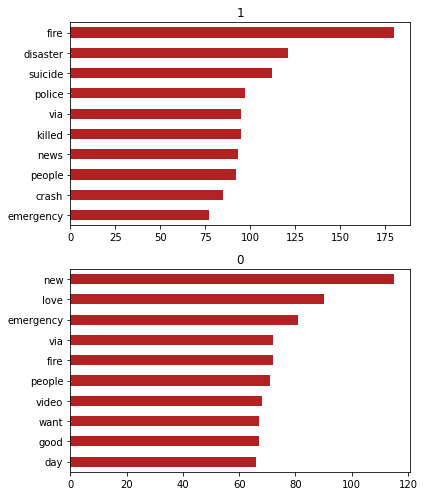

In [184]:

fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(6, 7))
for i, target in enumerate(tweets_tidy.target.unique()):
    df_temp = tweets_tidy[tweets_tidy.target == target]
    counts  = df_temp['token'].value_counts(ascending=False).head(10)
    counts.plot(kind='barh', color='firebrick', ax=axs[i])
    axs[i].invert_yaxis()
    axs[i].set_title(target)

fig.tight_layout()

**¿Qué   palabras   cree   que   le   servirán   para   hacer   un   mejor   modelo   de
clasificación?**

Palabras clave para tweets de desastres podrían ser: fire, disaster, news, suicide, police y killed

Palabras clave pra tweets de no desastres: body, love, video, time, youtube, gt

Las palabras **via** aparece en ambos tipos de tweets. La palabra **emergency** es un distractor porque aparece en tweets que no hablan de desastres reales y la palbra **fire** podría ser confusa por su alta frecuencia en ambos tipos de tweets.

In [185]:
# Cálculo term-frecuency (tf)
# ==============================================================================
tf = tweets_tidy.copy()
# Número de veces que aparece cada término en cada tweet
tf = tf.groupby(["id", "token"])["token"].agg(["count"]).reset_index()
# Se añade una columna con el total de términos por tweet
tf['total_count'] = tf.groupby('id')['count'].transform(sum)
# Se calcula el tf
tf['tf'] = tf["count"] / tf["total_count"]
tf.sort_values(by = "tf").head(5)

,id,token,count,total_count,tf
12426,2793,curfew,1,23,0.043478
12443,2793,whole,1,23,0.043478
12442,2793,tlk,1,23,0.043478
12441,2793,steal,1,23,0.043478
12440,2793,sound,1,23,0.043478


In [186]:
# Inverse document frequency
# ==============================================================================
idf = tweets_tidy.copy()
total_documents = idf["id"].drop_duplicates().count()
# Número de documentos (tweets) en los que aparece cada término
idf = idf.groupby(["token", "id"])["token"].agg(["count"]).reset_index()
idf['n_documentos'] = idf.groupby('token')['count'].transform(sum)
# Cálculo del idf
idf['idf'] = np.log(total_documents / idf['n_documentos'])
idf = idf[["token","n_documentos", "idf"]].drop_duplicates()
idf.sort_values(by="idf").head(3)

,token,n_documentos,idf
16312,fire,252,3.091583
46419,via,167,3.503019
32503,people,163,3.527262


In [187]:
# Term Frequency - Inverse Document Frequency
# ==============================================================================
tf_idf = pd.merge(left=tf, right=idf, on="token")
tf_idf["tf_idf"] = tf_idf["tf"] * tf_idf["idf"]
tf_idf.sort_values(by="id").head()

,id,token,count,total_count,tf,n_documentos,idf,tf_idf
0,1,allah,1,6,0.166667,8,6.541571,1.090262
84,1,reason,1,6,0.166667,17,5.787799,0.964633
8,1,deeds,1,6,0.166667,1,8.621013,1.436835
9,1,earthquake,1,6,0.166667,15,5.912962,0.985494
26,1,may,1,6,0.166667,60,4.526668,0.754445


In [188]:
# Reparto train y test
# ==============================================================================
datos_X = train2.loc[train2.target.isin([0, 1]), 'text']
datos_y = train2.loc[train2.target.isin([0, 1]), 'target']

X_train, X_test, y_train, y_test = train_test_split(
    datos_X,
    datos_y,
    test_size = 0.2,
    random_state = 123
    
)


In [189]:
value, counts = np.unique(y_train, return_counts=True)
print(dict(zip(value, 100 * counts / sum(counts))))
value, counts = np.unique(y_test, return_counts=True)
print(dict(zip(value, 100 * counts / sum(counts))))

{0: 55.848546315077755, 1: 44.151453684922245}
{0: 56.57657657657658, 1: 43.42342342342342}


In [190]:
stop_words = list(stopwords.words('english'))
# Se añade la stopword: amp, ax, ex
stop_words.extend(("amp", "xa", "xe"))
# Creación de la matriz tf-idf
# ==============================================================================
tfidf_vectorizador = TfidfVectorizer(
                        tokenizer  = limpiar_tokenizar,
                        min_df     = 3,
                        stop_words = stop_words
                    )
tfidf_vectorizador.fit(X_train)

C:\Users\eragr\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


TfidfVectorizer(min_df=3,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function limpiar_tokenizar at 0x000001AACA4F35E0>)

In [191]:
tfidf_train = tfidf_vectorizador.transform(X_train)
tfidf_test  = tfidf_vectorizador.transform(X_test)
print(f" Número de tokens creados: {len(tfidf_vectorizador.get_feature_names())}")
print(tfidf_vectorizador.get_feature_names()[:10])

 Número de tokens creados: 2890
['abandon', 'abandoned', 'abbswinston', 'abc', 'abcnews', 'abe', 'ability', 'ablaze', 'able', 'absolutely']


# Modelo SVM lineal

In [192]:
# Entrenamiento del modelo SVM
# ==============================================================================
modelo_svm_lineal = svm.SVC(kernel= "linear", C = 1.0)
modelo_svm_lineal.fit(X=tfidf_train, y= y_train)

# Grid de hiperparámetros
# ==============================================================================
param_grid = {'C': np.logspace(-5, 3, 10)}

# Búsqueda por validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = svm.SVC(kernel= "linear"),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = -2,
        cv         = 5, 
        verbose    = 0,
        return_train_score = True
      )

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid.fit(X = tfidf_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)

,param_C,mean_test_score,std_test_score,mean_train_score,std_train_score
5,0.278256,0.782513,0.005803,0.849392,0.002527
6,2.154435,0.772824,0.009670,0.930527,0.001294
7,16.681005,0.725040,0.006945,0.976223,0.000882
8,129.154967,0.713773,0.005417,0.983773,0.001242
9,1000.0,0.704755,0.008647,0.984167,0.001441
4,0.035938,0.558711,0.000639,0.560007,0.001794
0,0.00001,0.558485,0.000416,0.558485,0.000104
1,0.000077,0.558485,0.000416,0.558485,0.000104
2,0.000599,0.558485,0.000416,0.558485,0.000104
3,0.004642,0.558485,0.000416,0.558485,0.000104


In [193]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

modelo_final = grid.best_estimator_

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'C': 0.2782559402207126} : 0.7825126705059062 accuracy


In [194]:
# Error predicciones test
# ==============================================================================
predicciones_test = modelo_final.predict(X=tfidf_test)

print("-------------")
print("Error de test")
print("-------------")

print(f"Número de clasificaciones erróneas de un total de {tfidf_test.shape[0]} " \
      f"clasificaciones: {(y_test != predicciones_test).sum()}"
)
print(f"% de error: {100*(y_test != predicciones_test).mean()}")

print("")
print("-------------------")
print("Matriz de confusión")
print("-------------------")
pd.DataFrame(confusion_matrix(y_true = y_test, y_pred= predicciones_test),
             columns= [0, 1],
             index = [0, 1])

-------------
Error de test
-------------
Número de clasificaciones erróneas de un total de 1110 clasificaciones: 223
% de error: 20.09009009009009

-------------------
Matriz de confusión
-------------------


,0,1
0,560,68
1,155,327
